In [1]:
import numpy as np
import matplotlib.pylab as plt
import math as math
from scipy.optimize import fmin
from iminuit import Minuit, describe, Struct
from scipy.spatial import distance
from scipy.sparse import vstack

import time

#import lichen as lch
import seaborn as sns

%matplotlib  notebook

In [48]:
# Add code to the following function so that it takes in two datasets, loops over one of them, and finds
# information about the nearest neighbors in the other dataset, based on a flag. 

def nn(data0,data1,r=None,nneighbors=None):
    
    ret = -1
    ret_list=[]
    if r is not None and nneighbors is not None:
        exit(-1)
        return ret
    
    
    
    elif r is not None and nneighbors is None:
        rsq = r*r
        #for num0,num1 in zip(data0[0],data0[1]):
        for d in data0.transpose():
            count=0
            diffx=d[0]-data1[0]
            diffy=d[1]-data1[1]
            #diff= np.sqrt((num0-data1[0])**2 +(num1-data1[1])**2)
            #diff= np.sqrt(diffx*diffx + diffy*diffy)
            diff= diffx*diffx + diffy*diffy

            count = len(diff[diff<rsq])
            ret_list.append(float(count)/(float(len(data1[0]))*r))
        #print ret_list
        ret_list = np.array(ret_list)
        #print ret_list
        #exit()
        return ret_list
    
    
    
    
    elif r is None and nneighbors is not None:
        for num0 in data0:
            diff = np.abs(num0 - data1)
            diff.sort()
            radius= diff[nneighbors-1]
            ret_list.append(1/radius)
        ret_list = np.array(ret_list)
        return ret_list
    return ret

In [33]:
# Add code to the following function so that it takes in two datasets, loops over one of them, and finds
# information about the nearest neighbors in the other dataset, based on a flag. 

def nncdist(data0,data1,r=None,nneighbors=None):
    
    ret = -1
    ret_list=[]
    if r is not None and nneighbors is not None:
        exit(-1)
        return ret
    
    
    
    elif r is not None and nneighbors is None:
        #combined= np.vstack((data0[0],data0[1])).T  
        #combined1= np.vstack((data1[0],data1[1])).T
        combined = data0.transpose()
        combined1 = data1.transpose()
        #print data0.transpose()
        dist=distance.cdist(combined,combined1,'euclidean')
        for num in dist:
            count=len(num[num<r])
            #count =len(dist[dist<r])
            ret_list.append(float(count)/(float(len(data1[0]))*r))
        ret_list = np.array(ret_list)
        return ret_list
    
    
    
    
    elif r is None and nneighbors is not None:
        for num0 in data0:
            diff = np.abs(num0 - data1)
            diff.sort()
            radius= diff[nneighbors-1]
            ret_list.append(1/radius)
        ret_list = np.array(ret_list)
        return ret_list
    return ret

In [25]:
def normal(x,mean,width):
    return (1.0/(width*np.sqrt(2*np.pi)))*(np.exp(-(x-mean)**2/(2*(width**2))))

# A product of two Gaussians
def signal_2D(npts,means,sigmas):
    pts = []
    for m,s in zip(means,sigmas):
        pts.append(np.random.normal(m,s,npts))
        
    pts = np.array(pts)
    return pts

# Flat in 2D
def background_2D(npts,lovals,hivals):
    pts = []
    for lo,hi in zip(lovals,hivals):
        width = hi-lo
        pts.append(lo + width*np.random.random(npts))
        
    pts = np.array(pts)
    return pts

# Helper function to generate signal and background at the same time
def gen_sig_and_bkg(npts,means,sigmas,lovals,hivals):
    sigpts = signal_2D(npts[0],means,sigmas)
    bkgpts = background_2D(npts[1],lovals,hivals)

    data = [sigpts[0].copy(),sigpts[1].copy()]
    data[0] = np.append(data[0],bkgpts[0])
    data[1] = np.append(data[1],bkgpts[1])
    data = np.array(data)
   
    return data

In [26]:
# Test the tools to generate the datasets.

sigpts = signal_2D(3000,[5.0,7.0],[0.1,0.1])
#sns.jointplot(sigpts[0],sigpts[1],kind='hex')

bkgpts = background_2D(10000,[3.5,5],[6,9])
#sns.jointplot(bkgpts[0],bkgpts[1],kind='hex')

data1 = [sigpts[0].copy(),sigpts[1].copy()]
data1[0] = np.append(data1[0],bkgpts[0])
data1[1] = np.append(data1[1],bkgpts[1])
data1 = np.array(data1)

#sns.jointplot(data[0],data[1],kind='hex')

In [55]:
nbkg = 1000
sigmeans = [5.0,7.0]
sigwidths = [0.06,0.2]
bkglos = [3.5,5]
bkghis = [6,9]

def calc_pull(iterations, nsig, nMC, rad,cdist_bool):

    pull_frac_list=[]
    average_best_frac = 0
    frac = []
    fit_frac = []
    fit_frac_uncert = []
    frac_org = nsig/float(nsig+nbkg)
    

    for num in range(iterations):
        nsig_iteration = np.random.poisson(nsig)
        nbkg_iteration = np.random.poisson(nbkg)
        #nbkg_iteration = nbkg
        
        data = gen_sig_and_bkg([nsig_iteration,nbkg_iteration],sigmeans,sigwidths,bkglos,bkghis)
        #sns.jointplot(data[0],data[1],kind='hex')
        
        signal_points= signal_2D(nMC,sigmeans,sigwidths)
        background_points = background_2D(nMC,bkglos,bkghis)
        
        frac_iteration = float(nsig_iteration)/(float(nbkg_iteration+nsig_iteration))
        frac.append(frac_iteration)
        
        if cdist_bool:
            signal_prob=nncdist(data,signal_points, r=rad)
            background_prob= nncdist(data,background_points, r=rad)
        else:
            signal_prob=nn(data,signal_points, r=rad)
            background_prob = nn(data,background_points, r=rad)

        def tot_prob(frac):
            '''
            if cdist_bool:
                signal_prob_input=signal_prob_cdist
                background_prob_input=background_prob_cdist
                #print len(signal_prob_input)
            else:
                signal_prob_input=signal_prob
                background_prob_input=background_prob
                #print len(signal_prob_input)
            '''
            tot_prob=[]
            tot_prob.append(frac*signal_prob + ((1-frac)*background_prob))
            return np.array(tot_prob)
        
        def probability(frac):
            prob=tot_prob(frac)
            
            return -np.log(prob[prob>0]).sum()
            #return -np.log(tot_prob).sum()
        
        
        
        m1=Minuit(probability,frac= 0.2,limit_frac=(0.001,1),error_frac=0.001,errordef = 0.5,print_level=0)
        m1.migrad()
        #m.hesse()

        if (m1.get_fmin().is_valid):
            param=m1.values
            err=m1.errors
            fit_frac.append(param["frac"])
            fit_frac_uncert.append(err["frac"])
            pull_frac=(frac_org-param["frac"])/err["frac"]
            pull_frac_list.append(pull_frac)
            
    return pull_frac_list, frac, fit_frac, fit_frac_uncert,iterations

In [107]:
means=[]
stds=[]
means_cdist=[]
stds_cdist=[]

pulls_list ={}
for sig in [200]:
    for MC in [1000,10000,100000]:
        start = time.time()
        for rad in [0.01,0.05,0.1,0.15,0.20]: #, 0.10,0.20,0.50]:
            start = time.time()
            print 'number of signal points: %s \t number of MC point: %s \tradius: %s' % (sig,MC,rad)
            pulls,org_vals,fit_vals,fit_uncerts,iteration = calc_pull(1000, sig, MC, rad,False)
            name='MC' +str(MC) + 'rad'+str(rad)
            pulls_list[name]=pulls
            
            parameters_mean = {'signal': sig, 'MC_points': MC, 'radius': rad, 'mean pulls': np.mean(pulls)}
            means.append(parameters_mean)
            parameters_std = {'signal': sig, 'MC_points': MC, 'radius': rad, 'mean stds': np.std(pulls)}
            stds.append(parameters_std)
            print "time to calc 10 iterations: %f s" % (time.time() - start)
            '''
            start=time.time()
            pulls_cdist,org_vals_cdist,fit_vals_cdist,fit_uncerts_cdist,iteration_cdist = calc_pull(100, sig, MC, rad,True)
            parameters_mean_cdist = {'signal': sig, 'MC_points': MC, 'radius': rad, 'mean pulls': np.mean(pulls_cdist)}
            means_cdist.append(parameters_mean_cdist)
            parameters_std_cdist = {'signal': sig, 'MC_points': MC, 'radius': rad, 'mean stds': np.std(pulls_cdist)}
            stds_cdist.append(parameters_std_cdist)
            print "time to calc 10 iterations: %f s" % (time.time() - start)
            '''
            

print means
print stds
print '--------------------'
#print means_cdist
#print stds_cdist


#WITH THE POISSON and 100 iterations- TESTING IT

number of signal points: 200 	 number of MC point: 1000 	radius: 0.01
time to calc 10 iterations: 18.865947 s
number of signal points: 200 	 number of MC point: 1000 	radius: 0.05
time to calc 10 iterations: 20.570104 s
number of signal points: 200 	 number of MC point: 1000 	radius: 0.1
time to calc 10 iterations: 21.614159 s
number of signal points: 200 	 number of MC point: 1000 	radius: 0.15
time to calc 10 iterations: 22.248115 s
number of signal points: 200 	 number of MC point: 1000 	radius: 0.2
time to calc 10 iterations: 22.674481 s
number of signal points: 200 	 number of MC point: 10000 	radius: 0.01
time to calc 10 iterations: 102.358625 s
number of signal points: 200 	 number of MC point: 10000 	radius: 0.05
time to calc 10 iterations: 106.077753 s
number of signal points: 200 	 number of MC point: 10000 	radius: 0.1
time to calc 10 iterations: 108.159414 s
number of signal points: 200 	 number of MC point: 10000 	radius: 0.15
time to calc 10 iterations: 112.708652 s
numbe

<IPython.core.display.Javascript object>


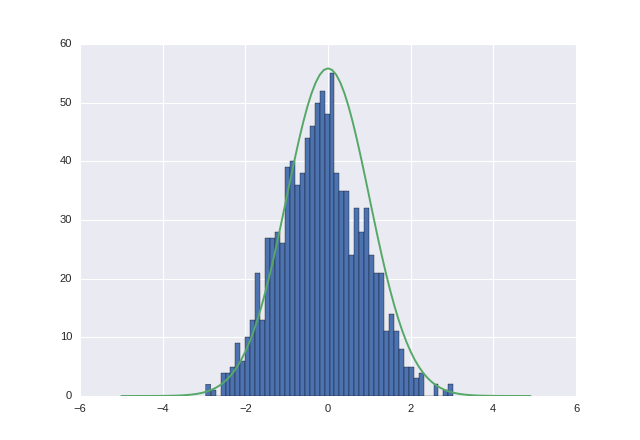

In [112]:

plt.figure()
plt.hist(pulls_list['MC100000rad0.1'],bins=50)
x = np.arange(-5,5,0.1)
y = 140*normal(x,0.0,1.0)
plt.plot(x,y)


In [ ]:
d0 = np.array([[1],[1]])
d1 = np.array([[3],[3]])

print nn(d0,d1,r=10)

In [ ]:
data = gen_sig_and_bkg([300,1000],sigmeans,sigwidths,bkglos,bkghis)
sns.jointplot(data[0],data[1],kind='hex')

#signal_points= signal_2D(10000,sigmeans,sigwidths)
background_points = background_2D(10000,bkglos,bkghis)
sns.jointplot(background_points[0],background_points[1],kind='hex')


In [ ]:
background_prob= nn(data,background_points, r=0.05)
print background_prob
print background_prob[background_prob<=0]

<IPython.core.display.Javascript object>


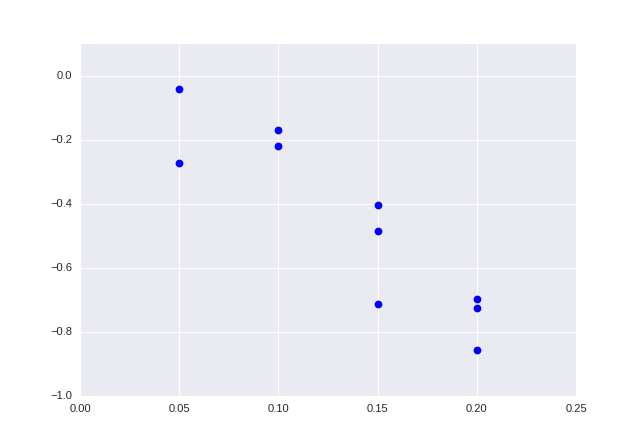

<IPython.core.display.Javascript object>


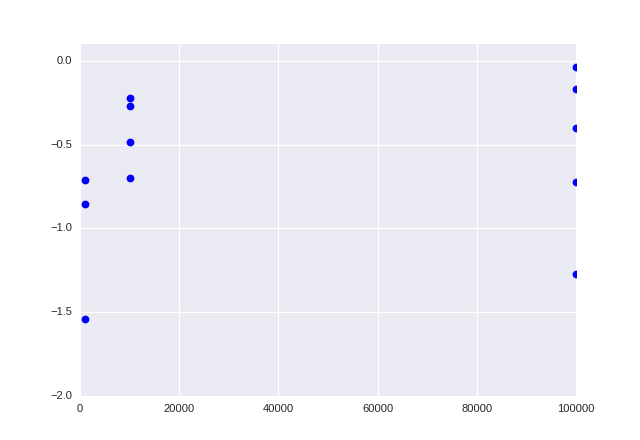

<IPython.core.display.Javascript object>


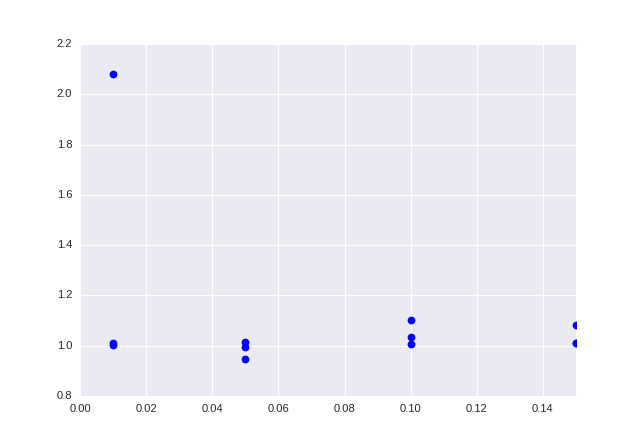

(0, 0.15)

In [118]:
plt.figure()
for item in means:
    plt.plot(item['radius'],item['mean pulls'], 'bo')
plt.ylim(-1,.1)
#plt.ylim(-.5,.5)
plt.figure()
for item in means:
    plt.plot(item['MC_points'],item['mean pulls'], 'bo')
plt.ylim(-2,.1)

plt.figure()
for item in stds:
    plt.plot(item['radius'],item['mean stds'], 'bo')
plt.xlim(0,.15)